In [14]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report

In [4]:
# 1. Tải dữ liệu
X_train = np.load('X_train.npy')
X_test = np.load('X_test.npy')
y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')

print(f"Dữ liệu Train: {X_train.shape}, Dữ liệu Test: {X_test.shape}")

Dữ liệu Train: (221, 30), Dữ liệu Test: (56, 30)


In [5]:
# 1. k-NN
knn_params = {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'uniform'} 
knn_model = KNeighborsClassifier(**knn_params)

# 2. Random Forest
rf_params = {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100} 
rf_model = RandomForestClassifier(random_state=42, **rf_params)

# 3. SVM (Lưu ý: probability=True bắt buộc để Stacking hoạt động tốt)
svm_params = {'C': 100, 'class_weight': None, 'gamma': 0.005, 'kernel': 'rbf'} 
svm_model = SVC(probability=True, random_state=42, **svm_params)

# 4. Decision Tree
dt_params = {'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'splitter': 'random'} # <--- Thay bằng best_params của bạn
dt_model = DecisionTreeClassifier(random_state=42, **dt_params)

# 5. AdaBoost
ada_params = {'algorithm': 'SAMME', 'estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.5, 'n_estimators': 300} # <--- Thay bằng best_params của bạn
ada_model = AdaBoostClassifier(random_state=42, **ada_params)

# 6. Gradient Boosting
gb_params = {'learning_rate': 0.1, 'max_depth': 5, 'max_features': None, 'min_samples_split': 2, 'n_estimators': 300, 'subsample': 0.8} # <--- Thay bằng best_params của bạn
gb_model = GradientBoostingClassifier(random_state=42, **gb_params)

# 7. XGBoost
xgb_params = {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 0.8} # <--- Thay bằng best_params
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, **xgb_params)

# 8. Logistic Regression (Base Learner - nếu bạn có tune nó)
lr_params = {'C': 100, 'solver': 'liblinear'}
lr_model = LogisticRegression(random_state=42, max_iter=1000, **lr_params)

# TỔNG HỢP CÁC ỨNG VIÊN
# Danh sách đầy đủ 8 mô hình đã được tối ưu
all_candidates = [
    ('knn', knn_model),
    ('rf', rf_model),
    ('svm', svm_model),
    ('dt', dt_model),
    ('ada', ada_model),
    ('gb', gb_model),
    ('xgb', xgb_model),
    ('lr', lr_model)
]

print(f"Đã khởi tạo {len(all_candidates)} mô hình với tham số tối ưu.")

Đã khởi tạo 8 mô hình với tham số tối ưu.


In [6]:
class OSEL_GeneticAlgorithm:
    def __init__(self, candidates, X, y, pop_size=10, generations=5, mutation_rate=0.1):
        self.candidates = candidates
        self.X = X
        self.y = y
        self.pop_size = pop_size
        self.generations = generations
        self.mutation_rate = mutation_rate
        self.num_models = len(candidates)
        
    def create_individual(self):
        # Tạo chuỗi nhị phân ngẫu nhiên (1: chọn mô hình, 0: không chọn)
        # Đảm bảo ít nhất 2 mô hình được chọn để Stacking hoạt động
        ind = [random.randint(0, 1) for _ in range(self.num_models)]
        if sum(ind) < 2: ind[random.randint(0, self.num_models-1)] = 1
        if sum(ind) < 2: ind[random.randint(0, self.num_models-1)] = 1
        return ind

    def calculate_fitness(self, individual):
        # Fitness Function: Độ chính xác Cross-Validation của Stacking Model tạo từ các model con
        selected_indices = [i for i, val in enumerate(individual) if val == 1]
        
        if len(selected_indices) < 2: 
            return 0.0 # Phạt nếu chọn quá ít model
        
        selected_estimators = [self.candidates[i] for i in selected_indices]
        
        # Meta-classifier là Logistic Regression (Standard cho Stacking)
        stack_clf = StackingClassifier(
            estimators=selected_estimators,
            final_estimator=LogisticRegression(),
            cv=3, # CV nội bộ
            n_jobs=-1
        )
        
        # Tính điểm Accuracy trung bình trên tập Train
        # Dùng cv=3 để chạy nhanh, thực tế nên dùng cv=5
        scores = cross_val_score(stack_clf, self.X, self.y, cv=3, scoring='accuracy')
        return scores.mean()

    def crossover(self, p1, p2):
        # Lai ghép 1 điểm
        point = random.randint(1, self.num_models - 1)
        c1 = p1[:point] + p2[point:]
        c2 = p2[:point] + p1[point:]
        return c1, c2

    def mutate(self, individual):
        # Đột biến: Đảo bit ngẫu nhiên
        for i in range(len(individual)):
            if random.random() < self.mutation_rate:
                individual[i] = 1 - individual[i]
        return individual

    def run(self):
        # Khởi tạo quần thể
        population = [self.create_individual() for _ in range(self.pop_size)]
        best_ind = None
        best_score = 0

        print(f"Bắt đầu chạy GA để tối ưu hóa cấu trúc Stacking...")
        for gen in range(self.generations):
            fitness_scores = []
            for ind in population:
                score = self.calculate_fitness(ind)
                fitness_scores.append(score)
                
                if score > best_score:
                    best_score = score
                    best_ind = ind[:]
            
            print(f"Generation {gen+1}/{self.generations} - Best CV Accuracy: {best_score:.4f}")
            
            # Chọn lọc tự nhiên (Lấy top 50%)
            sorted_pop = [x for _, x in sorted(zip(fitness_scores, population), key=lambda pair: pair[0], reverse=True)]
            parents = sorted_pop[:self.pop_size // 2]
            
            # Tạo thế hệ mới
            new_pop = parents[:]
            while len(new_pop) < self.pop_size:
                p1, p2 = random.sample(parents, 2)
                c1, c2 = self.crossover(p1, p2)
                new_pop.append(self.mutate(c1))
                if len(new_pop) < self.pop_size: new_pop.append(self.mutate(c2))
            
            population = new_pop
            
        return best_ind

In [7]:
# Cấu hình GA (Bạn có thể tăng pop_size lên 20 nếu máy mạnh)
ga = OSEL_GeneticAlgorithm(all_candidates, X_train, y_train, pop_size=10, generations=5)

# Chạy GA để tìm tổ hợp tối ưu
best_mask = ga.run()

# Lọc ra các mô hình chiến thắng
final_estimators = [all_candidates[i] for i, val in enumerate(best_mask) if val == 1]

print("\n" + "="*40)
print("KẾT QUẢ LỰA CHỌN CỦA GENETIC ALGORITHM")
print("="*40)
print("Các mô hình được chọn vào OSEL Stacking:")
for name, model in final_estimators:
    print(f" + {name}")

Bắt đầu chạy GA để tối ưu hóa cấu trúc Stacking...


/opt/anaconda3/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [15:30:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:519: Futu

Generation 1/5 - Best CV Accuracy: 0.9547


/opt/anaconda3/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [15:30:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[15:30:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

[15:30:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

[15:30:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

/opt/anaconda3/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [15:30:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[15:30:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } a

Generation 2/5 - Best CV Accuracy: 0.9592


/opt/anaconda3/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [15:30:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[15:30:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

[15:30:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

[15:30:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

/opt/anaconda3/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [15:30:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[15:30:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } a

Generation 3/5 - Best CV Accuracy: 0.9592


/opt/anaconda3/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [15:31:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:519: Futu

Generation 4/5 - Best CV Accuracy: 0.9592


/opt/anaconda3/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [15:31:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:519: Futu

Generation 5/5 - Best CV Accuracy: 0.9592

KẾT QUẢ LỰA CHỌN CỦA GENETIC ALGORITHM
Các mô hình được chọn vào OSEL Stacking:
 + knn
 + rf
 + svm
 + lr


In [31]:
print("\nĐang huấn luyện mô hình OSEL cuối cùng trên toàn bộ tập Train...")
# Xây dựng Stacking Classifier với tổ hợp tối ưu
osel_model = StackingClassifier(
    estimators=final_estimators,
    final_estimator=LogisticRegression(), # Meta-Learner
    cv=5,
    n_jobs=-1
)

osel_model.fit(X_train, y_train)


Đang huấn luyện mô hình OSEL cuối cùng trên toàn bộ tập Train...


StackingClassifier(cv=5,
                   estimators=[('knn',
                                KNeighborsClassifier(metric='manhattan',
                                                     n_neighbors=3)),
                               ('rf',
                                RandomForestClassifier(min_samples_leaf=2,
                                                       min_samples_split=5,
                                                       random_state=42)),
                               ('svm',
                                SVC(C=100, gamma=0.005, probability=True,
                                    random_state=42)),
                               ('lr',
                                LogisticRegression(C=100, max_iter=1000,
                                                   random_state=42,
                                                   solver='liblinear'))],
                   final_estimator=LogisticRegression(), n_jobs=-1)

In [32]:
# ==========================================
# 6. ĐÁNH GIÁ TRÊN TẬP TEST (FINAL EVALUATION)
# ==========================================
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
y_pred_final = osel_model.predict(X_test)
acc_final = accuracy_score(y_test, y_pred_final)

print("\n" + "="*40)
print(f"🏆 KẾT QUẢ CUỐI CÙNG (OSEL MODEL)")
print(f"Accuracy trên tập Test: {acc_final*100:.2f}%")
print("="*40)
print(classification_report(y_test, y_pred_final))
print("="*40)
print(f'F1_score : {f1_score(y_test, y_pred_final, average="weighted"):.4f}')
print(f'Accuracy score: {accuracy_score(y_test, y_pred_final):.4f}')


🏆 KẾT QUẢ CUỐI CÙNG (OSEL MODEL)
Accuracy trên tập Test: 98.21%
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        52
           1       1.00      0.75      0.86         4

    accuracy                           0.98        56
   macro avg       0.99      0.88      0.92        56
weighted avg       0.98      0.98      0.98        56

F1_score : 0.9810
Accuracy score: 0.9821


Exception ignored in: <function ResourceTracker.__del__ at 0x1077f1e40>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x104d35e40>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x1052f1e40>
Traceback (most recent call last

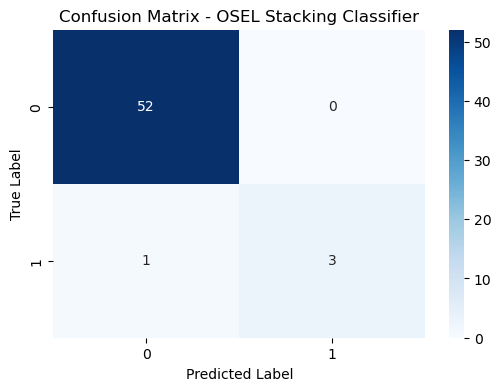

In [16]:
# 5. Vẽ Confusion Matrix (Tùy chọn để làm đẹp báo cáo)
model_name = "OSEL Stacking Classifier"
cm = confusion_matrix(y_test, y_pred_final)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix - {model_name}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()